<h1> draft for intial data Analysis </h1>

This notebook contain drafts for analysis functions, plotting functions, and scripts for the 6OHDA project

import modules and files:

In [2]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2


#inline
import os
#os.chdir('C:\\Users\\zemel\\Documents\\Reaserch\\PythonProjects\\6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *

collect data from all mice, and plot beta power over group by day:

In [6]:
baselines = getData('Processed.h5',['lfp','mvmt'],mice = '8430',period ='Pre',day = lambda x: int(x)==0)
early = getData('Processed.h5',['lfp','mvmt'],mice = '8430',period ='Pre',day = lambda x: (int(x)<= 4) & (x>0))
mid = getData('Processed.h5',['lfp','mvmt'],mice = '8430',period ='Pre',day = lambda x: (int(x)> 4) & (x<=10))
late = getData('Processed.h5',['lfp','mvmt'],mice = '8430',period ='Pre',day = lambda x: (int(x)> 10) & (x<=15))

cleaning up lfp data
cleaning up mvmt data
cleaning up lfp data
cleaning up mvmt data
cleaning up lfp data
cleaning up mvmt data
cleaning up lfp data
cleaning up mvmt data


In [3]:
def getPowerSpec(lfpDict):
    # This function takes in a dict with lfp data (that was returned from getData())
    # and returns the average power spectra
    # Inputs: 
    #   lfpDict - a dictionary with lfp data as returned from getData()
    # Outputs:
    #   M - mean power spectra
    #   Std - standard diviation of power spectra
    #   f - frequency list

    data = []
    for j in lfpDict:
        lfp = lfpDict[j]['lfp']['lfp']
        f, t, Sxx = signal.spectrogram(lfp[0,:],lfpDict[j]['lfp']['FS'],window=('hamming'),nperseg=140,noverlap =120,nfft=1200)

        Power = np.sum(Sxx,1)
        totPower = np.sum(Power)
        #beta = np.mean(getPowerInBand(f,Sxx,13,20)/np.sum(Sxx,axis = 0)
        data.append(Power/totPower)    


    l = len(data)
    data = np.array(data)
    M = np.mean(data,axis=0)
    Std = np.std(data, axis = 0)/l
    return M, Std, f

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


<IPython.core.display.Javascript object>


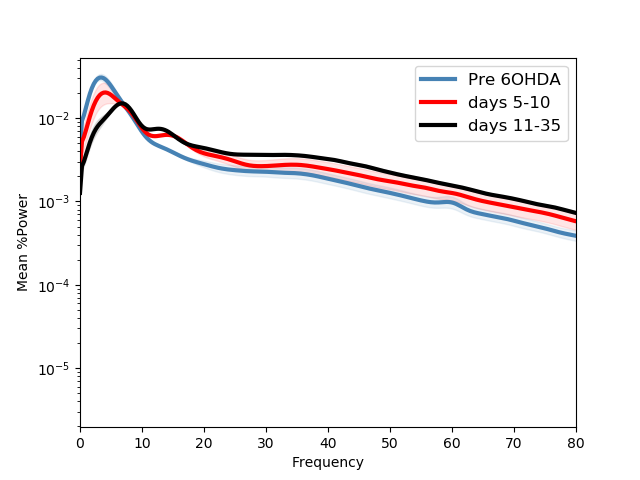

(0, 80)

In [21]:
#cond = ['baselines','early','mid','late']
cond = ['baselines','mid','late']
Names = {'baselines':'Pre 6OHDA','early':'days 1-4','mid':'days 5-10' ,'late':'days 11-35'}
Colors = {'baselines':'steelblue','early':'darkorange','mid':'red' ,'late':'black'}

for c in cond:
    M,Std, f = getPowerSpec(eval(c))
    plt.semilogy(f, M, linewidth=3,color=Colors[c],label=Names[c])
    plt.fill_between(f, M-Std, M+Std,color=Colors[c],alpha=0.1)
plt.ylabel('Mean %Power')
plt.xlabel('Frequency')
plt.legend(fontsize=12)
plt.xlim((0,80))

<IPython.core.display.Javascript object>


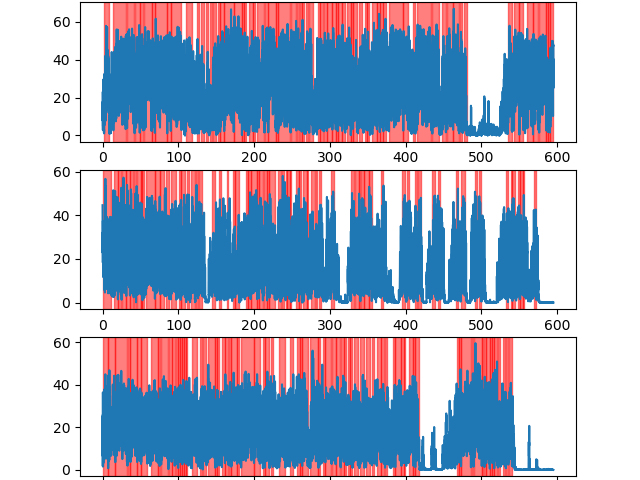

72 3271.0
71 6330.0
78 4392.0


<IPython.core.display.Javascript object>


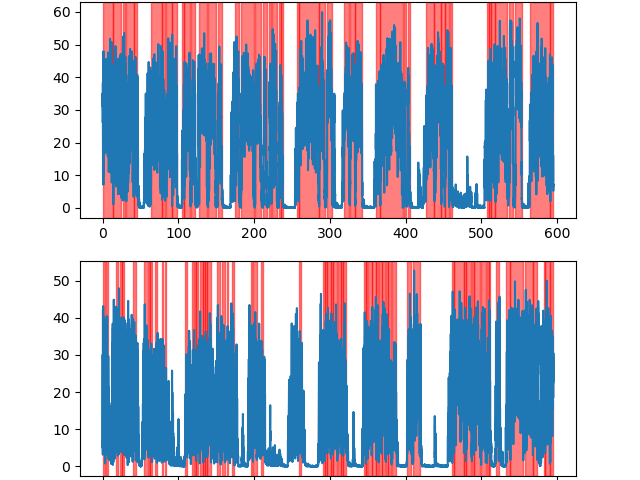

47 4385.0
65 6644.0


<IPython.core.display.Javascript object>


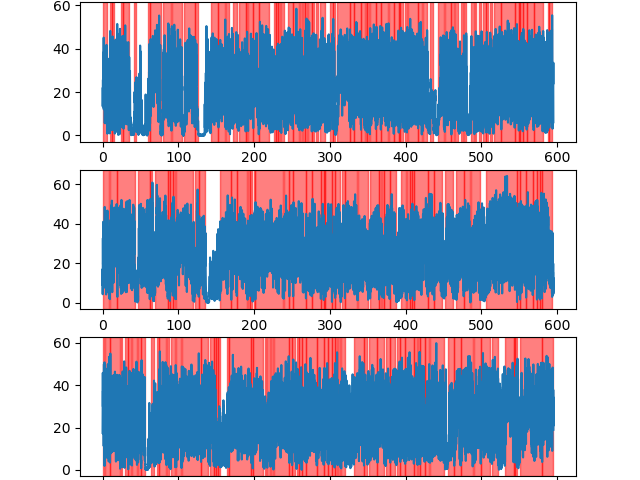

76 3076.0
56 1476.0
67 1843.0


<IPython.core.display.Javascript object>


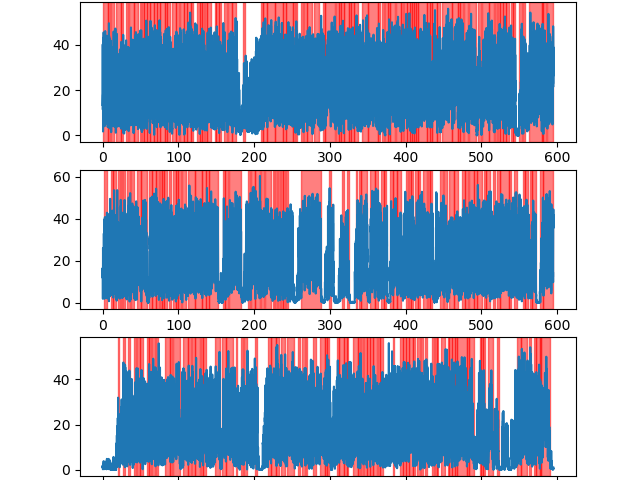

99 2403.0
84 4106.0
83 5109.0


In [69]:
for c in cond:
    data = eval(c)
    fig, ax = plt.subplots(len(data.keys()),1,gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})

     # random session, assuming all session have the same dt...
    #tPlot = np.linspace(-40*dt,40*dt,80)
    Tseconds = 2
   

    sessNum = 0
    for s in data.keys():
        dt = 1/data[s]['mvmt']['Fs'][0]  
        dataPoints = int(np.ceil(Tseconds/dt))
        #find movment onset:
        speed = data[s]['mvmt']['speed']
        lspeed =  butter_lowpass_filter(speed, 9.5, 1/dt, order=5)
        hiSpeed = lspeed >= 3
        d = np.diff(1*hiSpeed,axis=0)
#        print(d.shape,hiSpeed.shape)
        segments = {'start':[],'end':[]}

        if hiSpeed[0] ==1:
            tStart = 0
        else:
            tStart = None

        for l in range(0,len(d)):
            if d[l] == 1:
                tStart = l
            if d[l] == -1 and l-tStart > dataPoints:
                segments['start'].append(tStart)
                segments['end'].append(l)
                tStart = None

        if tStart is not None and np.sum(hiSpeed[tStart:]) > dataPoints:
            segments['start'].append(tStart)
            segments['end'].append(len(hiSpeed)-1)
    #    data[s]['highSpeed'] = segments
        # plot speed vd. onset:
        t = np.linspace(0,len(speed)*dt,len(speed))
#        ax[sessNum].plot(t[1:],d)
        ax[sessNum].plot(t,speed)
        d2 = np.ones(t.shape)
        for l in range(0, len(segments['start'])):
            ax[sessNum].axvspan(t[segments['start'][l]], t[segments['end'][l]], color='red', alpha=0.5)
            d2[segments['start'][l]:segments['end'][l]] = 0
        sessNum = sessNum +1
        print(len(segments['start']),np.sum(d2))

<IPython.core.display.Javascript object>


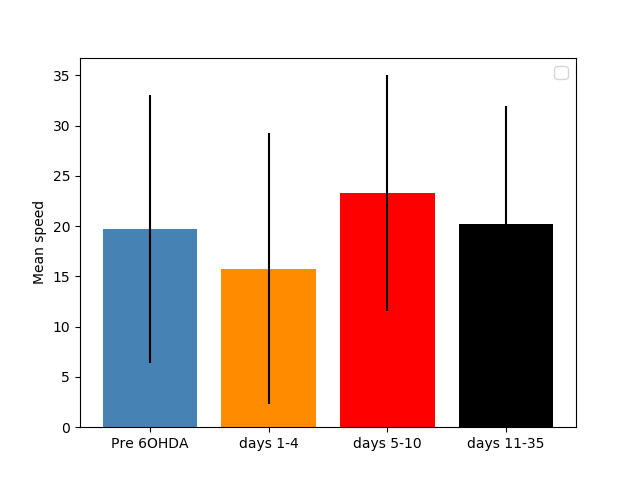

No handles with labels found to put in legend.


In [22]:
cond = ['baselines','early','mid','late']
#cond = ['baselines','mid','late']
Names = {'baselines':'Pre 6OHDA','early':'days 1-4','mid':'days 5-10' ,'late':'days 11-35'}
Colors = {'baselines':'steelblue','early':'darkorange','mid':'red' ,'late':'black'}
y_pos = np.arange(len(cond))
M = []
Std = []
for c in cond:
    d = eval(c)
    speed = np.empty((1,1))
    for j in d:
        speed = np.concatenate((d[j]['mvmt']['speed'],speed),axis=0)
    M.append(np.mean(speed))
    Std.append(np.std(speed))
plt.bar(y_pos, M, align='center',color=list(Colors.values()),yerr = Std)
plt.xticks(y_pos,list(Names.values()))
plt.ylabel('Mean speed')
#plt.xlabel('Frequency')
plt.legend(fontsize=12)
#plt.xlim((0,80))

In [3]:
#PVdataH = getData('Processed.h5',['trace','mvmt'],mice = '8430',period ='Pre',cre='PV',red=True, day=(lambda x: int(x)==0))
#PVdataP = getData('Processed.h5',['trace','mvmt'],mice = '8430',period ='Pre',cre='PV',red=True, day=(lambda x: int(x)>0))
#CHIdataH = getData('Processed.h5',['trace','mvmt'],period ='Pre',cre='CHI',red=True, day=(lambda x: int(x)==0))
#CHIdataP = getData('Processed.h5',['trace','mvmt'],period ='Pre',cre='CHI',red=True, day=(lambda x: int(x)>0))
MSNdataH = getData('Processed.h5',['trace','mvmt'],mice = '8430',period ='Pre',red=False, day=(lambda x: int(x)==0))
MSNdataP = getData('Processed.h5',['trace','mvmt'],mice = '8430',period ='Pre',red=False, day=(lambda x: (int(x)> 10) & (x<=15)))

cleaning up mvmt data
cleaning up mvmt data


In [92]:
def pairwiseCorr(X,method='pearson'):
    # this function calculates pairwaise corr for all columns in X
    Mdict = {'pearson':lambda x,y:sci.stats.pearsonr(x, y),
            'spearman':lambda x,y:sci.stats.spearmanr(x, y)}
    
    nCol = X.shape[1]
    co = np.empty((nCol,nCol,2))
    
    for i in range(nCol):
        for j in range(i,nCol):
            [cor,pval] = Mdict[method](X[:,i],X[:,j])
            co[i,j,0] = cor
            co[j,i,0] = cor
            co[j,i,1] = pval
            co[i,j,1] = pval
    return co

Check how many sessions left in each condition:

In [93]:
cond = ['MSNdataH','MSNdataP']
Coeff = {'MSNdataH':{'high':[],'low':[]},'MSNdataP':{'high':[],'low':[]}}
for c in cond:
    data = eval(c)
    Tseconds = 2
    sessNum = 0
    for s in data.keys():
        dt = 1/data[s]['mvmt']['Fs'][0]  
        dataPoints = int(np.ceil(Tseconds/dt))
        #find movment onset:
        speed = data[s]['mvmt']['speed']
        lspeed =  butter_lowpass_filter(speed, 9.5, 1/dt, order=5)
        hiSpeed = lspeed >= 3
        d = np.diff(1*hiSpeed,axis=0)
        segments = {'start':[],'end':[]}

        if hiSpeed[0] ==1:
            tStart = 0
        else:
            tStart = None

        for l in range(0,len(d)):
            if d[l] == 1:
                tStart = l
            if d[l] == -1 and l-tStart > dataPoints:
                segments['start'].append(tStart)
                segments['end'].append(l)
                tStart = None

        if tStart is not None and np.sum(hiSpeed[tStart:]) > dataPoints:
            segments['start'].append(tStart)
            segments['end'].append(len(hiSpeed)-1)
            
        t = np.linspace(0,len(speed)*dt,len(speed))
        d2 = np.zeros(t.shape)
        for l in range(0, len(segments['start'])):
            d2[segments['start'][l]:segments['end'][l]] = 1
        
        traces = data[s]['trace']['dff']
        Coeff[c]['high'].append(pairwiseCorr(traces[:,d2==1]))
        Coeff[c]['low'].append(pairwiseCorr(traces[:,d2==0]))
        
        sessNum = sessNum +1


because there aren't any current CHI session, remove from cond list: 

In [12]:
cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA','MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA'}
Colors = {'PVdataH':'mediumseagreen','PVdataP':'darkgreen','MSNdataH':'cornflowerblue','MSNdataP':'navy'}

Visially inspect how traces looks:

<IPython.core.display.Javascript object>


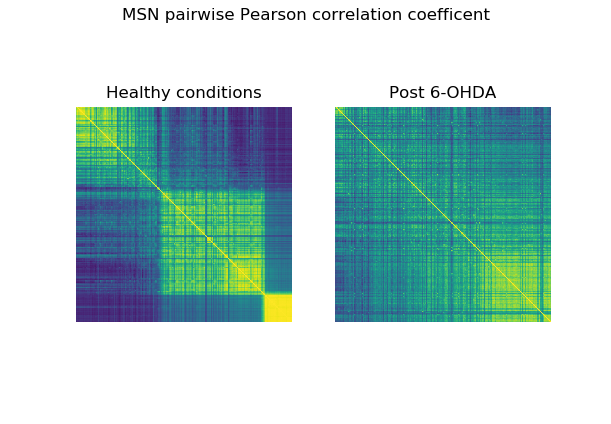

Text(0.5,1,'Healthy conditions')

In [107]:
fig, ax = plt.subplots(1,2)
#for s in range(0,3):
s=2
ax[0].imshow(Coeff['MSNdataH']['high'][s][:,:,0])
ax[1].imshow(Coeff['MSNdataP']['high'][s][:,:,0])
ax[0].axis('off')
ax[1].axis('off')
fig.suptitle('MSN pairwise Pearson correlation coefficent')
ax[1].set_title('Post 6-OHDA')
ax[0].set_title('Healthy conditions')
    #ax[2,s].imshow(Coeff['MSNdataH']['low'][s][:,:,0])
    #ax[3,s].imshow(Coeff['MSNdataP']['low'][s][:,:,0])


In [96]:
Coeff['MSNdataH']['high'][s].shape

(8630, 8630, 2)

<b>** make a note to double check all traces and remove the bad ones prior to making final struct file</b>

for now: continue with the analysis.
find onset of Ca events - align to movement onset and plot


<IPython.core.display.Javascript object>


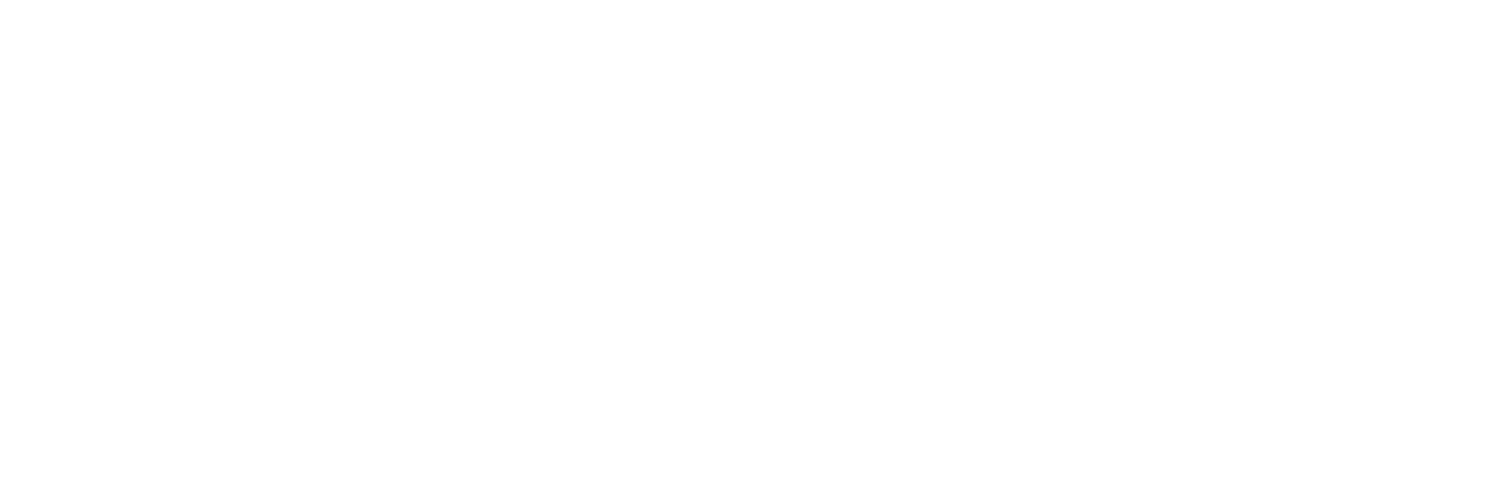

KeyError: '1236_BaselineA'

In [16]:
fig, ax = plt.subplots(1,3,figsize=(15, 5))

de = {}

dt = 1/PVdataH['1236_BaselineA']['trace']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt,40*dt,80)


for c in cond:
    data = eval(c)
    for s in data.keys():
        
        # Vectors are saved as column vectors so.. transposed to raw vector
        if data[s]['trace']['dff'].shape[1] == 1:
            data[s]['trace']['dff'] = data[s]['trace']['dff'].T
                
        sOnset = FindMvmtOnset(data[s]['mvmt']['speed'],hi = 25)    
        print(data[s]['trace']['dff'].T.shape)
        caOnset = formatCaOnset(data[s]['trace']['dff'].T,th = 2, th2 = 3)
        
        sA = alignToOnset(data[s]['trace']['dff'].T, sOnset, winPost=40,winPre=40)
        
        cAs = np.empty((tPlot.size,0))
        #n = 0
        for p in range(0,caOnset.shape[1]):
            al = alignToOnset(data[s]['mvmt']['speed'], caOnset[:,p], winPost=40,winPre=40)
            if al.ndim ==1:
                al.shape = (tPlot.size,1)
        #    n = n +al.shape[1]
            cAs = np.concatenate((cAs,np.mean(al,1,keepdims=True)),axis=1)
        
        cAr = np.empty((tPlot.size,0))
        for p in range(0,caOnset.shape[1]):
            al = alignToOnset(data[s]['mvmt']['rot'], caOnset[:,p], winPost=40,winPre=40)
            if al.ndim ==1:
                al.shape = (tPlot.size,1)
            cAr = np.concatenate((cAs,np.mean(al,1,keepdims=True)),axis=1)

        if len(sA.shape) > 2:
            sA = np.mean(sA,2)
            if 'sAligned' not in locals():
#                print(s+' :',sA.shape)
                sAligned = sA
            else:
#                print(s+' :',sA.shape,sAligned.shape)
                sAligned = np.concatenate((sAligned,sA),axis=1)
        
        print(cAs.shape)
        
        if cAs.ndim > 1:
#            cAs = np.mean(cAs,1)
            if 'caAlignedS' not in locals():
    #           print(s+' :',sA.shape)
                caAlignedS = cAs
            else:
#                print(s+' :',cAs.shape,caAlignedS.shape)
                caAlignedS = np.concatenate((caAlignedS,cAs),axis=1)

        if cAr.ndim > 1:
#            cAr = np.mean(cAr,1)
            if 'caAlignedR' not in locals():
    #            print(s+' :',sA.shape)
                caAlignedR = cAr
            else:
                print(s+' :',cAr.shape,caAlignedR.shape)
                caAlignedR = np.concatenate((caAlignedR,cAr),axis=1)

    
    PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c],Label=Names[c],mesErr=True)
    PlotRelativeToOnset(ax[1],caAlignedS,tPlot,Color=Colors[c],Label=Names[c],mesErr=True)
    PlotRelativeToOnset(ax[2],caAlignedR,tPlot,Color=Colors[c],Label=Names[c],mesErr=True)
    del sAligned
    del caAlignedS
    del caAlignedR
ax[0].legend(fontsize=12)

<IPython.core.display.Javascript object>


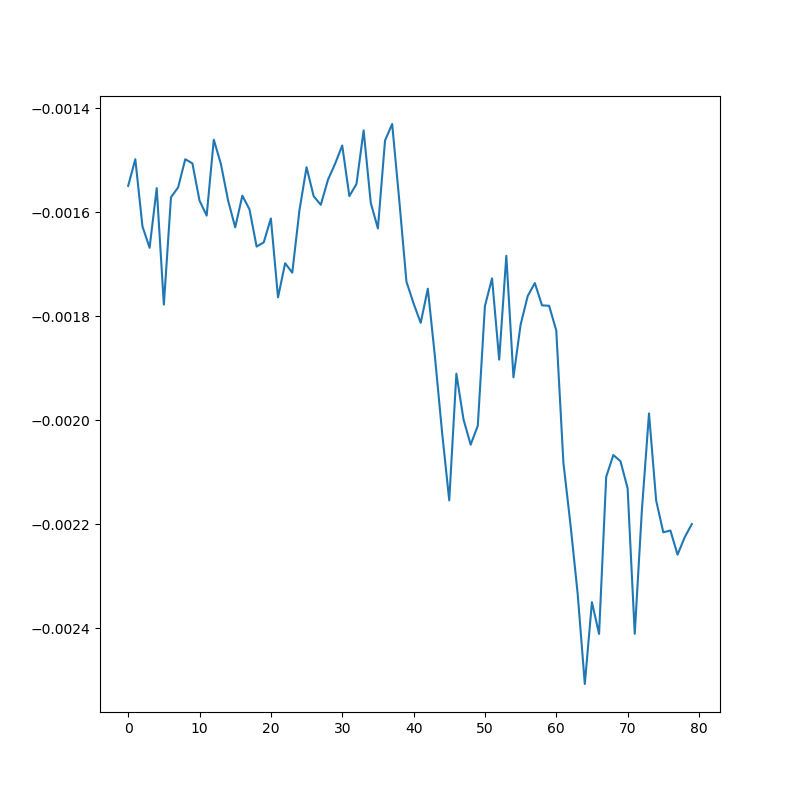

In [14]:
c  = cond[2]
fig, ax = plt.subplots(1,1,figsize=(8, 8))
#PlotRelativeToOnset(ax,de[c],tPlot,Color=Colors[c],Label=Names[c],mesErr=True)
plt.plot(np.nanmean(de[c],axis=1))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 5.0))
plt.plot(PVdataH['8803_BaselineA']['mvmt']['speed'])

In [36]:
#del sAligned
#del caAlignedS
#del caAlignedR
del data


In [43]:
%%timeit 
cAs = np.empty((tPlot.size,0))
for p in range(0,caOnset.shape[1]):
    al = alignToOnset(data[s]['mvmt']['speed'], caOnset[:,p], winPost=40,winPre=40)
    if al.ndim ==1:
        al.shape = (tPlot.size,1)
    cAs = np.concatenate((cAs,al),axis=1)

5.22 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit 
cAs = np.empty((tPlot.size,0))
n = 0
for p in range(0,caOnset.shape[1]):
    al = alignToOnset(data[s]['mvmt']['speed'], caOnset[:,p], winPost=40,winPre=40)
    if al.ndim ==1:
        al.shape = (tPlot.size,1)
    n = n +al.shape[1]
    cAs = np.concatenate((cAs,np.mean(al,1,keepdims=True)),axis=1)
print(cAs.shape)

(80, 509)
(80, 509)
(80, 509)
(80, 509)
(80, 509)
(80, 509)
(80, 509)
(80, 509)
823 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
cAs.shape

(80, 44259)

In [46]:
caOnset.shape

(11901, 509)

In [66]:
from utils import alignToOnset

<IPython.core.display.Javascript object>


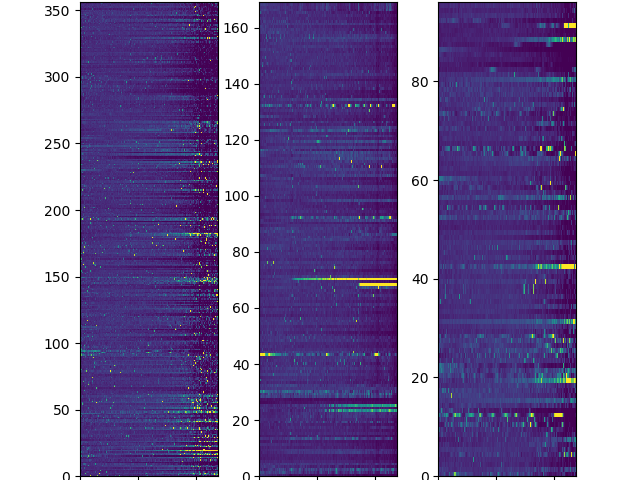

<IPython.core.display.Javascript object>


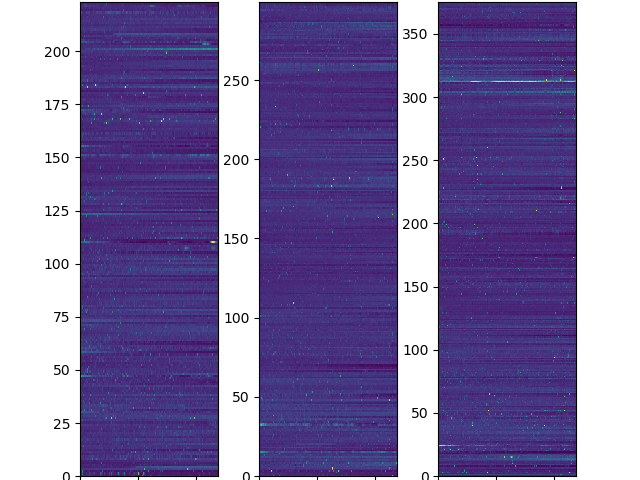

In [14]:
cond = ['MSNdataH','MSNdataP']
for c in cond:
    data = eval(c)
    fig, ax = plt.subplots(1,len(data.keys()),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
    sessNum = 0
    for s in data.keys():
        ax[sessNum].pcolormesh(data[s]['trace']['dff'],vmin=-1,vmax=6)
        sessNum =sessNum+1

NameError: name 'cond' is not defined